In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mpld3

**Add column names**

In [2]:
opkort = pd.read_csv(Path('../20210324/opkort.csv'), header=None, sep=';')
opkort_gammal = pd.read_csv(Path('../inte_så_kul/res/gamla/op_kort_filt.csv'), sep=';')
opkort.columns = opkort_gammal.columns
opkort.to_csv(Path('../20210324/with_name/op_kort_namn.csv'))

In [3]:
ingrepp = pd.read_csv(Path('../20210324/op_ingrepp.csv'), header=None, sep=';')
ingrepp_gammal = pd.read_csv(Path('../inte_så_kul/res/gamla/ingrepp_ingrepp.csv'), sep=';')
ingrepp.columns = ingrepp_gammal.columns
ingrepp.to_csv(Path('../20210324/with_name/op_ingrepp_namn.csv'))

In [4]:
diagnos = pd.read_csv(Path('../20210324/op_diagnos.csv'), header=None, sep=';')
diagnos_gammal = pd.read_csv(Path('../inte_så_kul/res/gamla/ingrepp_diagnos.csv'), sep=';')
diagnos.columns = diagnos_gammal.columns
diagnos.to_csv(Path('../20210324/with_name/op_diagnos_namn.csv'))

**LOAD DATA AND COMBINE INTO 1 DF**

**Behandling**
* Der_Behandling_PK
* Der_Opkort_FK -> op_kort
* Der_Anestesikort_FK -> Anestesikort (Har inte fått än)
* Der_Vårdform_FK
* Der_Prioritet_FK
* BehandlingsStatus - Kanske behöver filtreras bort
* ASAklass
* Der_PeropUtskriventill_FK - Vad fan menas??
* ForberedelsetidStartTidpunkt
* ForberedelsetidSlutTidpunkt
* PatientÅlderVidOp - står i dagar
* Veckodag? kanske
* Starttimme? kanske
* BMI
* Kroppslängd - del av BMI
* Kroppsvikt - del av BMI

**Op-kort** - Hur kopplas behandling till OP-kort (Tror inte att vi behöver någonting härifrån)
* Der_Opkort_PK -> behandling
* OpkortText - har en kod i början
* OpkortUndergruppKod
* OpkortHubudgruppKod
* TidFöreMin - Är det kopplat till en behandling?

**Op-ingrepp**
* Der_Behandling_PK -> behandling
* Ingreppskod - primär, kanske sekundär (se Primär_Sekundär)
* Primär_Sekundär
* Sida

**Op-diagnos**
* Der_Behandling_PK -> behandling
* Diagnoskod - primär, kanske sekundär (se Primär_Sekundär)
* Primär_Sekundär

In [3]:
# Lead behandling and select relevant columns
behandling = pd.read_csv(Path('../20210324/with_name/behandling_optillfälle.csv'), sep=';')
behandling = behandling[['Der_Behandling_PK',
                         'Der_Opkort_FK',
                         'Der_Anestesikort_FK',
                         'Der_Vårdform_FK',
                         'Der_Prioritet_FK',
                         'BehandlingsStatus',
                         'ASAklass',
                         'ForberedelsetidStartTidpunkt',
                         'ForberedelsetidSlutTidpunkt',
                         'PatientÅlderVidOp',
                         'Veckodag',
                         'Starttimme',
                         'BMI',
                         'Kroppslängd',
                         'Kroppsvikt',
                        ]]
behandling = behandling[behandling['BehandlingsStatus'] == 'Opererad'] # Remove 'abrutna' operationer as they do not contain all relevant data
print("Behandling length: {}".format(len(behandling)))

# Load ingrepp and select relevant columns
ingrepp = pd.read_csv(Path('../20210324/with_name/op_ingrepp_namn.csv'))
ingrepp = ingrepp[['Der_Behandling_PK',
                   'Ingreppkod',
                   'Primär_Sekundär',
                   'Sida',
                  ]]
ingrepp = ingrepp[ingrepp['Primär_Sekundär'] == 'Primär'] # Might want to include this if we make a more complicated model
print("Ingrepp length: {}".format(len(ingrepp)))

# Load diagnos and select relevant columns
diagnos = pd.read_csv(Path('../20210324/with_name/op_diagnos_namn.csv'))
diagnos = diagnos[['Der_Behandling_PK',
                   'Diagnoskod',
                   'Primär_Sekundär',
                  ]]
diagnos = diagnos[diagnos['Primär_Sekundär'] == 'Primär'] # Might want to include this if we make a more complicated model
print("Diagnos length: {}".format(len(diagnos)))

# Combine the data frames
combined_df = behandling.merge(diagnos, on='Der_Behandling_PK').merge(ingrepp, on='Der_Behandling_PK')
print("Combined length: {}".format(len(combined_df)))

Behandling length: 4581
Ingrepp length: 4757
Diagnos length: 4582
Combined length: 4563


C:\Users\gidja1\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (80,81) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


**CALCULATE AND ADD PREOPTIME TO DATAFRAME**

In [4]:
# Bad algoritm for checking min and max time of förbereds
start = combined_df["ForberedelsetidStartTidpunkt"].dropna()
slut = combined_df["ForberedelsetidSlutTidpunkt"].dropna()

start_times = []
for time in start:
    minn = int(time[-9:-7])
    hour = int(time[-12:-10])
    minutes = hour*60 + minn
    start_times.append(minutes)
    
stop_times = []
for time in slut:
    minn = int(time[-9:-7])
    hour = int(time[-12:-10])
    minutes = hour*60 + minn
    stop_times.append(minutes)

times = []
for i in range(len(start_times)):
    #print(stop_times[i], start_times[i], stop_times[i] - start_times[i])
    times.append(stop_times[i] - start_times[i])
    
print(max(times))
print(min(times))

# Add total time to dataframe
combined_df['time'] = times

414
0


**ASAKLASS**

Text(0.5, 1.0, 'ASAKLASS - Preoptid')

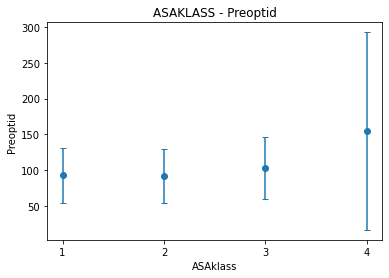

In [5]:
asa_mean = []
asa_std = []
for i in range(6):
    asa = combined_df[combined_df['ASAklass'] == i+1]
    time = asa['time']
    asa_mean.append(time.mean())
    asa_std.append(time.std())
    
plt.errorbar(['1', '2', '3', '4', '5', '6'], asa_mean, asa_std, marker='o', linestyle='None', capsize=3)
plt.xlabel('ASAklass')
plt.ylabel('Preoptid')
plt.title("ASAKLASS - Preoptid")

Nr of data points:
* ASA 1 - 1935
* ASA 2 - 1731
* ASA 3 - 267
* ASA 4 - 3

**BMI, KROPPSVIKT, KROPPSLÄNGD**

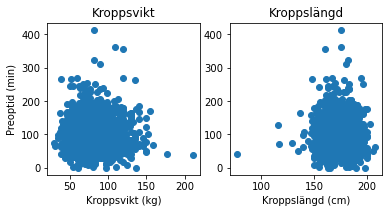

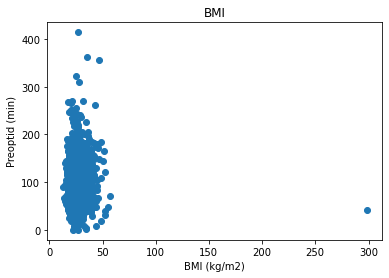

In [6]:
figure, axis = plt.subplots(1,2)
axis[1].set_box_aspect(1)
axis[0].set_box_aspect(1)

axis[0].set_title('Kroppsvikt')
axis[0].set_ylabel('Preoptid (min)')
axis[0].set_xlabel('Kroppsvikt (kg)')

axis[1].set_title('Kroppslängd')
axis[1].set_xlabel('Kroppslängd (cm)')

axis[0].scatter(combined_df['Kroppsvikt'], combined_df['time'])
axis[1].scatter(combined_df['Kroppslängd'], combined_df['time'])

figure2, axis2 = plt.subplots(1)
axis2.set_title('BMI')
axis2.set_ylabel('Preoptid (min)')
axis2.set_xlabel('BMI (kg/m2)')
axis2.scatter(combined_df['BMI'], combined_df['time'])

**ÅLDER**

Text(0, 0.5, 'Preoptid (min)')

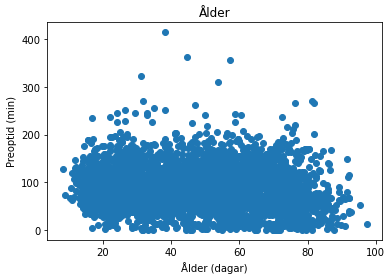

In [7]:
plt.scatter(combined_df['PatientÅlderVidOp']/365, combined_df['time'])
plt.title('Ålder')
plt.xlabel('Ålder (dagar)')
plt.ylabel('Preoptid (min)')

**VÅRDFORM**

<ErrorbarContainer object of 3 artists>

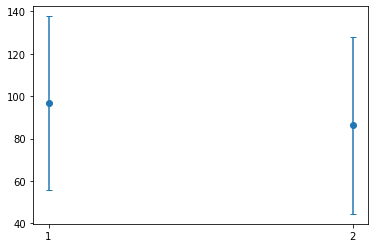

In [8]:
form_mean = []
form_std = []
for i in range(2):
    form = combined_df[combined_df['Der_Vårdform_FK'] == i+1]
    time = form['time']
    form_mean.append(time.mean())
    form_std.append(time.std())
    
plt.errorbar(['1','2'], form_mean, form_std, marker='o', linestyle='None', capsize=3)

In [9]:
plt.rcParams["figure.figsize"] = (20,5)

In [22]:
diagnoser = {}
for diagnost in combined_df['Diagnoskod']:
    diagnos = diagnost[0]
    if diagnos not in diagnoser.keys():
        diagnoser[diagnos] = 1
    else:
        value = diagnoser[diagnos]
        diagnoser[diagnos] = value +1
print(diagnoser)

{'T': 607, 'M': 1440, 'S': 2060, 'G': 160, 'Z': 181}


In [11]:
true_diagnoser = {}
for diagnos in diagnoser:
    if diagnos[0] == 'M' or diagnos[0] == 'G' or diagnos[0] == 'Z' or diagnos[0] == 'S' or diagnos[0] == 'T':
        true_diagnoser[diagnos] = diagnoser[diagnos]

combined_df = combined_df[combined_df['Diagnoskod'].isin(true_diagnoser)]
print(combined_df)
#plt.bar(true_diagnoser.keys(), true_diagnoser.values())
print("Nr of diagnoser: {}".format(sum(true_diagnoser.values())))

      Der_Behandling_PK  Der_Opkort_FK  Der_Anestesikort_FK  Der_Vårdform_FK  \
0                387543         130348                   -1                2   
1                509966          26159                   -1                2   
2                695604         177053                 5095                2   
3                482134          26020                 5914                2   
4                299790         130609                 5909                2   
...                 ...            ...                  ...              ...   
4556             100097          77362                 4984                2   
4558             668988          28502                 5909                2   
4559             223046          63230                 6012                2   
4560             295019          58909                 5914                2   
4561             294111          58947                 6026                2   

      Der_Prioritet_FK BehandlingsStatu

In [12]:
ingrepp_plural = {}
ingreppsgrupp = []
for index, row in combined_df.iterrows():
    ingrepp = row['Ingreppkod']
    ingrepp_group = ingrepp[0:2]
    ingreppsgrupp.append(ingrepp_group)
    if ingrepp_group not in ingrepp_plural.keys():
        ingrepp_plural[ingrepp_group] = 1
    else:
        value = ingrepp_plural[ingrepp_group]
        ingrepp_plural[ingrepp_group] = value +1
print(ingrepp_plural)
combined_df['ingreppsGrupp'] = ingreppsgrupp

{'TN': 442, 'NC': 1005, 'NH': 737, 'NB': 649, 'NG': 932, 'TA': 5, 'NF': 244, 'ND': 280, 'AC': 65, 'ZZ': 11, 'QC': 4, 'PG': 2, 'QD': 11, 'XN': 27, 'AB': 1, 'QB': 1, 'DQ': 4, 'DR': 1, 'TQ': 1, 'NE': 7, 'XX': 14, 'AV': 5}


<BarContainer object of 22 artists>

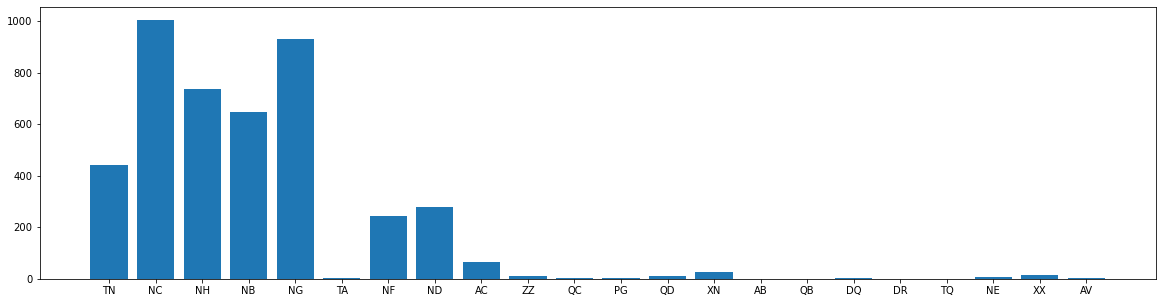

In [13]:
plt.bar(ingrepp_plural.keys(), ingrepp_plural.values())

<BarContainer object of 5 artists>

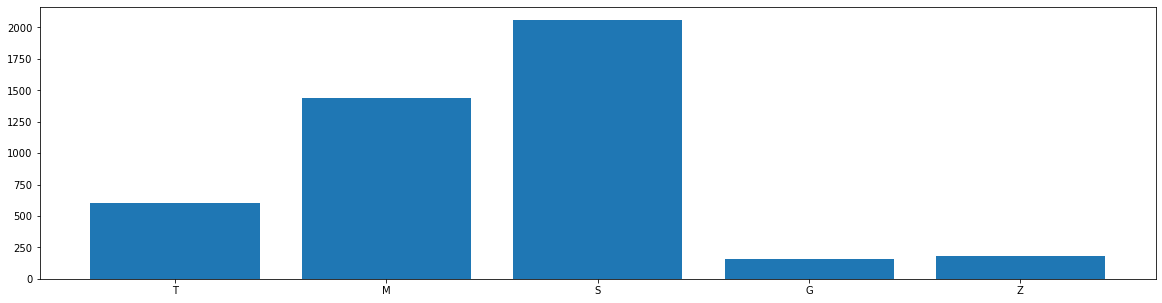

In [23]:
plt.bar(diagnoser.keys(), diagnoser.values())

In [14]:
fetures_df = combined_df.drop(["Der_Behandling_PK", 
                               "Der_Opkort_FK",
                               "Der_Anestesikort_FK",
                               "BehandlingsStatus",
                               "ForberedelsetidStartTidpunkt",
                               "ForberedelsetidSlutTidpunkt",
                               "Primär_Sekundär_x",
                               "Primär_Sekundär_y",
                            ], axis='columns')
fetures_df.head()

,Der_Vårdform_FK,Der_Prioritet_FK,ASAklass,PatientÅlderVidOp,Veckodag,Starttimme,BMI,Kroppslängd,Kroppsvikt,Diagnoskod,Ingreppkod,Sida,time,ingreppsGrupp
0,2,2,NaN,29434.0,5.0,8.0,NaN,NaN,NaN,T840,TNG10,Höger,116,TN
1,2,3,NaN,16841.0,2.0,7.0,NaN,NaN,NaN,M258,TNH10,Höger,29,TN
2,2,1,3.0,15658.0,1.0,16.0,24.4,173.0,73.0,S5250,NCJ69,Vänster,88,NC
3,2,5,1.0,27854.0,2.0,11.0,29.1,169.0,83.0,T932,NHU49,Vänster,46,NH
4,2,6,NaN,21777.0,1.0,10.0,24.4,190.0,88.0,M610,NCH31,Vänster,95,NC


In [15]:
ingreppsgrupper = {}
for ingreppsgrupp, ingreppsgrupp_df in fetures_df.groupby('ingreppsGrupp'):
    ingreppsgrupper[ingreppsgrupp] = ingreppsgrupp_df

In [16]:
grupp_mean = []
grupp_std = []
for ingreppsgrupp in ingreppsgrupper.keys():
    df = fetures_df[fetures_df['ingreppsGrupp'] == ingreppsgrupp]
    grupp_mean.append(df['time'].mean())
    grupp_std.append(df['time'].std())

<ErrorbarContainer object of 3 artists>

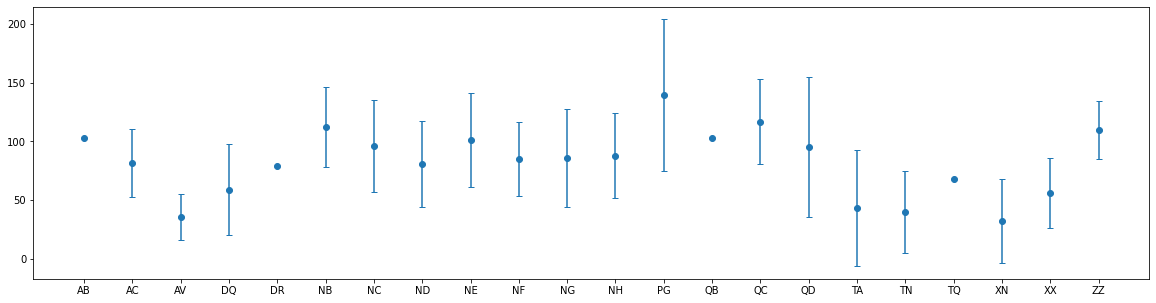

In [17]:
plt.errorbar(ingreppsgrupper.keys(), grupp_mean, grupp_std, marker='o', linestyle='None', capsize=3)

Preoptime seam to differ quite alot in different ingrepps groups